In [1]:
%matplotlib inline

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
import matplotlib.pyplot as plt

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
print(device)

cuda:0


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



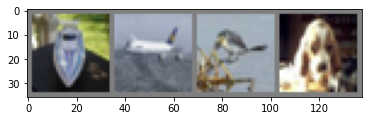

 ship plane  bird   dog


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [54]:
import torch.nn as nn
import torch.nn.functional as F
from attention import AttentionConv

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        """
        self.conv1 = nn.Sequential(
            AttentionConv(3, 8, kernel_size=5, padding=2, groups=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )
        """
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        #self.conv2 = nn.Conv2d(8, 16, 5)
        self.conv2 = nn.Sequential(
            AttentionConv(8, 16, kernel_size=5, padding=2, groups=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.fc1 = nn.Linear(16 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)

Net(
  (conv1): Sequential(
    (0): AttentionConv(
      (key_conv): Conv2d(3, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (query_conv): Conv2d(3, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (value_conv): Conv2d(3, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): AttentionConv(
      (key_conv): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (query_conv): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (value_conv): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fc1): Linear(in_features=1024, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features

In [55]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [56]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [57]:
net.conv1.register_forward_hook(get_activation('conv1'))
net.conv2.register_forward_hook(get_activation('conv2'))

In [58]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs = data[0].to(device)
        labels = data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.966
[1,  4000] loss: 1.725
[1,  6000] loss: 1.654
[1,  8000] loss: 1.605
[1, 10000] loss: 1.559
[1, 12000] loss: 1.543
[2,  2000] loss: 1.502
[2,  4000] loss: 1.454
[2,  6000] loss: 1.458
[2,  8000] loss: 1.457
[2, 10000] loss: 1.436
[2, 12000] loss: 1.416
[3,  2000] loss: 1.399
[3,  4000] loss: 1.353
[3,  6000] loss: 1.368
[3,  8000] loss: 1.338
[3, 10000] loss: 1.358
[3, 12000] loss: 1.338
[4,  2000] loss: 1.306
[4,  4000] loss: 1.293
[4,  6000] loss: 1.301
[4,  8000] loss: 1.283
[4, 10000] loss: 1.303
[4, 12000] loss: 1.279
[5,  2000] loss: 1.246
[5,  4000] loss: 1.254
[5,  6000] loss: 1.252
[5,  8000] loss: 1.225
[5, 10000] loss: 1.262
[5, 12000] loss: 1.246
[6,  2000] loss: 1.210
[6,  4000] loss: 1.207
[6,  6000] loss: 1.207
[6,  8000] loss: 1.207
[6, 10000] loss: 1.198
[6, 12000] loss: 1.208
[7,  2000] loss: 1.156
[7,  4000] loss: 1.176
[7,  6000] loss: 1.184
[7,  8000] loss: 1.173
[7, 10000] loss: 1.164
[7, 12000] loss: 1.186
[8,  2000] loss: 1.119
[8,  4000] 

In [59]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

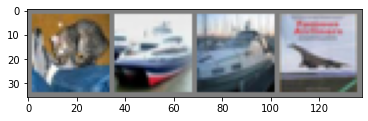

GroundTruth:    cat  ship  ship plane


In [60]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(16)))

In [61]:
net = Net()
net.load_state_dict(torch.load(PATH))
net.to(device)

Net(
  (conv1): Sequential(
    (0): AttentionConv(
      (key_conv): Conv2d(3, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (query_conv): Conv2d(3, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (value_conv): Conv2d(3, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): AttentionConv(
      (key_conv): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (query_conv): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (value_conv): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fc1): Linear(in_features=1024, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features

In [62]:
outputs = net(images.to(device))

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [63]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat plane  ship  bird


In [64]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        inputs = data[0].to(device)
        labels = data[1].to(device)
        # calculate outputs by running images through the network 
        outputs = net(images.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 10 %


In [65]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        inputs = data[0].to(device)
        labels = data[1].to(device)    
        outputs = net(images.to(device))    
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

  
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                   accuracy))

Accuracy for class plane is: 26.0 %
Accuracy for class car   is: 0.0 %
Accuracy for class bird  is: 26.3 %
Accuracy for class cat   is: 24.3 %
Accuracy for class deer  is: 0.0 %
Accuracy for class dog   is: 0.0 %
Accuracy for class frog  is: 0.0 %
Accuracy for class horse is: 0.0 %
Accuracy for class ship  is: 26.1 %
Accuracy for class truck is: 0.0 %


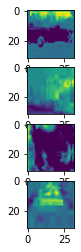

In [66]:
act = activation['conv1'].squeeze().cpu()
fig, axarr = plt.subplots(act.size(0))
for idx in range(act.size(0)):
    axarr[idx].imshow(act[idx][0])